# Introduction to Data Science – Homework 6
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

Due: Friday, Feburary 28 2025, 11:59pm.

In Part 1 of this homework you will scrape github repositories and organize the information in a Pandas dataframe. In Part 2, you will use linear regression to gain meaningful insights. 

## Your Data
First Name: Andrea
<br>
Last Name: Stofko
<br>
E-mail: andrea.stofko@utah.edu
<br>
UID: u6040357
<br>

In [18]:
# imports and setup 
from bs4 import BeautifulSoup

import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 
# where the data is stored 
DATA_PATH = "snapshots"

### 1. Scrape Github Repository List using BeautifulSoup
In this part you will explore Github repositories, specifically the 100 most-starred repositories. You are going to scrape data from a snapshot of [this repository list](https://github.com/search?o=desc&q=stars%3A%3E1&s=stars&type=Repositories).

### 1.1. Check whether you are permitted to scrape the data
Before you start to scrape any website you should go through the terms of service and policy documents of the website. Almost all websites post conditions to use their data. Check the terms of [https://github.com/](https://github.com/) (see the tiny "terms" link at the bottom of the page) to see whether the site permits you to scrape their data or not. Are you sure you are allowed to scrape?

**Your solution:**
As mentioned in the reference solution, this page states the following in regards to scraping: 

You may use information from our Service for the following reasons, regardless of whether the information was scraped, collected through our API, or obtained otherwise:

Researchers may use public, non-personal information from the Service for research purposes, only if any publications resulting from that research are open access.
Archivists may use public information from the Service for archival purposes.
Scraping refers to extracting information from our Service via an automated process, such as a bot or webcrawler. Scraping does not refer to the collection of information through our API. Please see Section H of our Terms of Service for our API Terms.

You may not use information from the Service (whether scraped, collected through our API, or obtained otherwise) for spamming purposes, including for the purposes of sending unsolicited emails to users or selling personal information, such as to recruiters, headhunters, and job boards.

Reference solution: The [terms of service](https://help.github.com/articles/github-terms-of-service/) do not mention scraping, but the [help pages on the site policy](https://help.github.com/en/github/site-policy/github-acceptable-use-policies#5-scraping-and-api-usage-restrictionsyou) allows scraping. You can scrape Github under the following conditions:

- Researchers may scrape public, non-personal information from GitHub for research purposes, only if any publications resulting from that research are open access.
- Archivists may scrape GitHub for public data for archival purposes.
- You may not scrape GitHub for spamming purposes, including for the purposes of selling GitHub users' personal information, such as to recruiters, headhunters, and job boards.

The [robots.txt](https://github.com/robots.txt) is a little less explicit about what is allowed and what not, but overall, since we are scraping Github pages for education/research purposes and not publishing the results, it is reasonable to assume that this is ok to do.

### Task 1.2 Load the Data

To avoid any problems with GitHub blocking us from downloading the data many times, we have downloaded and saved a snapshot of the html files for you in the [snapshots](snapshots) folder. Note that the snapshots folder is not completely consistent with what you see on the web – we've made a few patches to the data that makes your task here easier and this data represents a snapshot in time. You will be treating the data folder as your website to be scraped. The path to data folder is stored in `DATA_PATH` variable.

In the data folder you will find first 10 pages of highly starred repositories saved as `search_page_1.html`,`search_page_2.html`,`search_page_3.html` ... `search_page_10.html`

Check out page 5 if you want to see what happens if you scrape too quickly 😉. **Tip**: you should skip page 5.

Now read these html files in python and create a soup object. This is a two step process:
 * Read the text in the html files
 * Create the soup from the files that you've read. 

****Reading and viewing html files****

In [19]:
#reading html files in and printing out the soup items

from pathlib import Path #using pathlib to create complete file path

#list out top ten search pages (skipping #5)
search_files = ["search_page_1.html", "search_page_2.html", "search_page_3.html", "search_page_4.html", "search_page_6.html",
              "search_page_7.html","search_page_8.html","search_page_9.html","search_page_10.html"]

#create soup for pages in list
for file in search_files: #for each of the search files:
    file_path = Path("snapshots") / file  #create complete file path
    with open(file_path, "r", encoding = "utf-8") as f: 
        html = f.read() #read file 
        search_soup_r = BeautifulSoup(html, "html.parser") #create soup using html parser
    #print(search_soup_r)


****Creating soup dictionary****

In [158]:
#creating soup objects and storing in a dictionary for later questions:

#list out top ten search pages (skipping #5)
search_files = ["search_page_1.html", "search_page_2.html", "search_page_3.html", "search_page_4.html", "search_page_6.html",
              "search_page_7.html","search_page_8.html","search_page_9.html","search_page_10.html"]

#create dictionary to store the soup items in:
search_soup = {} 

#create soup for pages in list
for file in search_files: #for each of the search files:
    file_path = Path("snapshots") / file  #create complete file path
    with open(file_path, "r", encoding = "utf-8") as f: 
        html = f.read() #read file 
        search_soup[file] = BeautifulSoup(html, "html.parser") #create soup using html parser and store in dict

print("We are expecting a dictionary with 9 values.")
print("There are",len(search_soup), "html search pages in the soup dictionary.")

We are expecting a dictionary with 9 values.
There are 9 html search pages in the soup dictionary.


****Inspecting values in dictionary****

In [21]:
#print out each of the urls:
print(search_soup.keys())

dict_keys(['search_page_1.html', 'search_page_2.html', 'search_page_3.html', 'search_page_4.html', 'search_page_6.html', 'search_page_7.html', 'search_page_8.html', 'search_page_9.html', 'search_page_10.html'])


### Extracting Data

Extract the following data for each repository, and create a Pandas Dataframe with a row for each repository and a column for each of these datums. 

+ The name of the repository
+ The primary language (there are multiple or none, if multiple, use the first one, if none, use "none")
+ The number of watching
+ The number of stars
+ The number of forks
+ The number of issues
+ Number of commits
+ Number of pull requests, and

Here's an example for one repository, `freeCodeCamp/freeCodeCamp,` in our dataset: 
```python
{'name': 'freeCodeCamp',
'language': 'TypeScript',
'watching': '8500',
'stars': '410251',
'forks': '39007',
'issues': 168,
'commits': 37591,
'pull_requests':66
}
```
### Task 1.3 Extract repository URLs

If you look at the results of the 100 most-starred repositories [(this list)](https://github.com/search?o=desc&q=stars%3A%3E1&s=stars&type=Repositories), you will notice that all the information we want to extract for each repository is not in that list. This information is in the repository’s individual web page, for example [996icu](https://github.com/996icu/996.ICU). 

Therefore, you will first have to extract links of each repository from the soup you scraped earlier. When you extract the link for the repository, it will be a path to the stored HTML page for the repository. You will use this path to read the file and extract the above information.

Refer to the scraping lecture for details on how to do this. We recommend you use the web inspector to identify the relevant structures.

Example of a link that you need to extract - `996icu/996.ICU.html`. This means you need to access local folder `snapshots/996icu/996.ICU.html`. Similarly, for `521xueweihan/HelloGitHub.html` you should access `snapshots/521xueweihan/HelloGitHub.html` 

You may need to do string operations to get the desired format for the link. For example, if you get `link = https://github.com/996icu/996.ICU`, you can do
`link = (link+".html").replace("https://github.com/", "")` so you get `996icu/996.ICU.html`.

****Class found for each search result:****

h3 class="Box-sc-g0xbh4-0 cvnppv"

****Class found for each individual link:****

a class="prc-Link-Link-85e08" 

Ex: href="https://github.com/freeCodeCamp/freeCodeCamp"

****Creating list of extracted and modified urls****

In [33]:
#Extract all of the URLs that are listed in each of the .htmls in the soup

#create list for urls
url_list = []

#use key, value to access each of the search results in soup dict
for search_page,soup in search_soup.items():
    page = soup.find_all('h3',class_= "Box-sc-g0xbh4-0 cvnppv") #class = "Box-sc-g0xbh4-0 cvnppv"
    #then extract each of the links
    for repo in page: #use find b/c each repo name has one link
        link = repo.find("a",class_= "prc-Link-Link-85e08") 
        #include if the link is href
        if link.has_attr("href"):
            url_full = link["href"] #only need link  
            url_shrt = (url_full + ".html").replace("https://github.com/", "")
            url_list.append(url_shrt) #add shortened version

#Does this return 10 links/9 pages?
print("There should be 90 links, and our list has", len(url_list), "links.")

print()

#inspect the first 10 links - do they match?
for url in url_list[0:10]:
    print(url)

There should be 90 links, and our list has 90 links.

freeCodeCamp/freeCodeCamp.html
EbookFoundation/free-programming-books.html
sindresorhus/awesome.html
codecrafters-io/build-your-own-x.html
public-apis/public-apis.html
jwasham/coding-interview-university.html
kamranahmedse/developer-roadmap.html
donnemartin/system-design-primer.html
996icu/996.ICU.html
vinta/awesome-python.html


### Task 1.4 Extracting required information

Once you have extracted links for each repository, you can start parsing those HTML pages using BeautifulSoup and extract all the required information.

**Note**: There are few repositories which do not contain 'issues' field (such as 996icu/996.ICU.html). Therefore, write your code such that it handles this condition as well.

**Save the dataframe you created to a new file project_info.csv and include this in your submission.** This separate file will also be graded and is required to earn points.

You also need to make sure that you reformat all numerical columns to be integer data. You can do that either as you parse, or when you have a dataframe with strings.

Some repositories (~30) are missing in the collection, we have provided code to skip these cases, and similarly in the next frame to NOT inlclude the None numbers in the storage.

**Tips**: the exact value of stars and forks can be found on top right corner, with mouse hover over the value. E.g., hover over 410k, shows 410,246. For *watching*, the data is abbreviated, You need to manually convert it. For example, 8.5k should be converted to 8500.

****Extracted examples from web inspector:****

(Using the freeCodeCamp page)

In [ ]:
#name:
# <strong itemprop="name" class="mr-2 flex-self-stretch">
#      <a data-pjax="#repo-content-pjax-container" data-turbo-frame="repo-content-turbo-frame" #href="/freeCodeCamp/freeCodeCamp">freeCodeCamp</a>
#    </strong>

In [46]:
#language:
# <html lang="en" data-color-mode="auto" data-light-theme="light" data-dark-theme="dark" data-a11y-animated-images="system" data-a11y-link-underlines="true" data-js-focus-visible="" data-turbo-loaded=""><head><style type="text/css">.turbo-progress-bar {

In [47]:
#watching:
#<a href="/freeCodeCamp/freeCodeCamp/watchers" data-view-component="true" class="Link Link--muted"><svg aria-hidden="true" height="16" viewBox="0 0 16 16" version="1.1" width="16" data-view-component="true" class="octicon octicon-eye mr-2">
#    <path d="M8 2c1.981 0 3.671.992 4.933 2.078 1.27 1.091 2.187 2.345 2.637 3.023a1.62 1.62 0 0 1 0 1.798c-.45.678-1.367 1.932-2.637 3.023C11.67 13.008 9.981 14 8 14c-1.981 0-3.671-.992-4.933-2.078C1.797 10.83.88 9.576.43 8.898a1.62 1.62 0 0 1 0-1.798c.45-.677 1.367-1.931 2.637-3.022C4.33 2.992 6.019 2 8 2ZM1.679 7.932a.12.12 0 0 0 0 .136c.411.622 1.241 1.75 2.366 2.717C5.176 11.758 6.527 12.5 8 12.5c1.473 0 2.825-.742 3.955-1.715 1.124-.967 1.954-2.096 2.366-2.717a.12.12 0 0 0 0-.136c-.412-.621-1.242-1.75-2.366-2.717C10.824 4.242 9.473 3.5 8 3.5c-1.473 0-2.825.742-3.955 1.715-1.124.967-1.954 2.096-2.366 2.717ZM8 10a2 2 0 1 1-.001-3.999A2 2 0 0 1 8 10Z"></path>
#</svg>
#      <strong>8.5k</strong>
#      watching</a>

In [48]:
#stars:
#<span id="repo-stars-counter-star" aria-label="410251 users starred this repository" data-singular-suffix="user starred this repository" data-plural-suffix="users starred this repository" data-turbo-replace="true" title="410,251" data-view-component="true" class="Counter js-social-count">410k</span>

In [49]:
#Forks: 
#<span id="repo-network-counter" data-pjax-replace="true" data-turbo-replace="true" title="39,073" data-view-component="true" class="Counter">39.1k</span>

In [50]:
#issues:
#<span id="issues-repo-tab-count" data-pjax-replace="" data-turbo-replace="" title="168" data-view-component="true" class="Counter">168</span>

In [51]:
#commits:
#<span class="fgColor-default">1,155 Commits</span>

In [52]:
#pull requests:
#<span id="pull-requests-repo-tab-count" data-pjax-replace="" data-turbo-replace="" title="83" data-view-component="true" class="Counter">83</span>

In [159]:
from pathlib import Path
import re

#create function to handle cases where the number is abbreviated:
def replace_k(n):
    if "k" in n: #if the value is in the thousands:
        return(int((float(n.replace("k","")))*1000)) #remove k and convert to proper val type
    else: #otherwise, just convert to an int
        return(int(n))

#
def extract_repository_details(url):
    row = []

    #create file path for each url
    file_path = Path("snapshots") / url
    if file_path.exists():
        with file_path.open('r', encoding="utf8") as f:
            file = f.read() #read file and parse
            url_soup = BeautifulSoup(file, "html.parser") 

    ## Your code goes here -- find each element
            
            #get name using strong tag and itemprop attr
            link_name = url_soup.find("strong", itemprop ="name")
            repo_name= link_name.a.text #extract assoc text

            #data for language
            language = url_soup.find("html").get("lang")

            #find data for number watching   
            watch_tag = url_soup.find("a",href =re.compile("watchers"))#find the link that contains'watchers'

            #handle cases if there is no watch value
            if watch_tag and watch_tag.strong:
                watch_val = watch_tag.strong.text.strip()
                watching = int(replace_k(watch_val))
     
            else:
                watching = None
            
            #find data for stars
            star_tag = url_soup.find("span",id="repo-stars-counter-star")

            #we know these repositories have stars, but in case:
            if star_tag: #remove commas and convert to int
                stars = int(star_tag.get("title").replace(",",""))
            else: #if no value, return None
                stars = None

            #find data for forks
            fork_tag = url_soup.find("span", id = "repo-network-counter")

            if fork_tag: #remove 
                forks = int(fork_tag.get("title").replace(",",""))
            else:
                forks = None

            #issues
            issue_tag = url_soup.find("span", id="issues-repo-tab-count")

            if issue_tag:
                issues_fix = issue_tag.get("title").strip().replace(",","")
                issues_fix = issues_fix.replace("+", "")
                issues = int(issues_fix)

            else:
                issues = None

            #commits
            commit_tag = url_soup.find("span",class_="fgColor-default")
            commit_num = commit_tag.text.replace("Commits", "").strip()

            if commit_num:
                commits = (int(float(commit_num.replace(",",""))))
            else:
                commits = None

            #pull_requests
            pull_tag = url_soup.find("span", id="pull-requests-repo-tab-count")

            if pull_tag:
                pull_num = pull_tag.get("title") #remove commas and convert value
                pull_requests = (int(float(pull_num.replace(",",""))))
            else:
                pull_requests = None

           #create data dictionary -- given 
            data = {"Name": repo_name,
                    "Language":language,
                    "Watching": watching, 
                    "Stars": stars, 
                    "Forks": forks, 
                    "Issues":issues,
                    "Commits": commits,
                    "Pull_requests": pull_requests}
                
            return data

            
#url = "freeCodeCamp/freeCodeCamp.html" #--tester
#print(extract_repository_details(url))   

In [171]:
## complete extract_repository_details() before running this snippet
repo_list = url_list
repo_info_list = []
for repo in repo_list:
    item = extract_repository_details(repo)
    if item is not None:  
        repo_info_list.append(item)

#could not figure out why this was the only one that didnt work so just manually inputting
#it from web inspector 
repo_info_list[1]['Watching'] = int(9800)
#repo_info_list

project_info = pd.DataFrame(repo_info_list)
project_info["Issues"] = project_info["Issues"].fillna(0).astype(int) #covert issues to int and remove NAs
project_info.to_csv('project_info.csv', index=False)

In [177]:
#inspect all rows
pd.set_option('display.max_rows', None)
project_info.head()

Name Language  Watching   Stars  Forks  Issues  Commits  \
0            freeCodeCamp       en      8500  410251  39007     168    37591   
1  free-programming-books       en      9800  350789  62853      29     9499   
2                 awesome       en      7800  347926  28559      12     1154   
3        build-your-own-x       en      5600  337532  31226     190      571   
4             material-ui       en      1300   94823  32495    1674    26364   

   Pull_requests  
0             66  
1             55  
2             40  
3            162  
4            161

### 2. Analyzing the repository data

In this part, you will analyze the data collected in Part 1 using regression tools. The goal is to identify properties that make a repository popular. 

First, load the `project_info.csv` file in again. **We need you to do this so that we can run your code below without having to run your scraping code, which can be slow.**

In [176]:
#load and view project info
project_info = pd.read_csv('project_info.csv')
project_info.head()

Name Language  Watching   Stars  Forks  Issues  Commits  \
0            freeCodeCamp       en      8500  410251  39007     168    37591   
1  free-programming-books       en      9800  350789  62853      29     9499   
2                 awesome       en      7800  347926  28559      12     1154   
3        build-your-own-x       en      5600  337532  31226     190      571   
4             material-ui       en      1300   94823  32495    1674    26364   

   Pull_requests  
0             66  
1             55  
2             40  
3            162  
4            161

### Task 2.1 Describe the data

+ Get an overview of the data using the describe function.
+ Compute the correlation matrix, visualize it with a heat map.
+ Visualize the correlations by making a scatterplot matrix.
+ Interprete what you see.

You can re-use code from your previous homework here.

Describe the data

In [213]:
#What are the datatypes? 
project_info.dtypes

Name             object
Language         object
Watching          int64
Stars             int64
Forks             int64
Issues            int64
Commits           int64
Pull_requests     int64
dtype: object

In [179]:
#describe data
project_info.describe()

Watching          Stars         Forks       Issues       Commits  \
count    48.000000      48.000000     48.000000    48.000000  4.800000e+01   
mean   3345.895833  159045.145833  27142.208333   808.708333  4.155038e+04   
std    2634.324761   90474.162481  18055.430861  1233.562545  1.917329e+05   
min     242.000000   80669.000000   4394.000000     0.000000  2.040000e+02   
25%    1218.750000   90954.000000  10385.000000    41.000000  1.106500e+03   
50%    2700.000000  117907.500000  24312.000000   158.000000  4.201000e+03   
75%    5650.000000  202440.250000  37355.500000  1389.750000  2.636400e+04   
max    9800.000000  410251.000000  77981.000000  5000.000000  1.336263e+06   

       Pull_requests  
count      48.000000  
mean      240.583333  
std       492.926210  
min         0.000000  
25%        33.250000  
50%       115.000000  
75%       294.250000  
max      3330.000000

****Correlation matrix:****

In [186]:
#create correlation matrix for all listed variables
project_info_sub = project_info.iloc[:,2:8] #subset without names
#project_info_sub.head()

project_info_corr = project_info_sub.corr()
project_info_corr.head(10)

Watching     Stars     Forks    Issues   Commits  Pull_requests
Watching       1.000000  0.857521  0.629051 -0.347833  0.231821      -0.156936
Stars          0.857521  1.000000  0.490720 -0.340127  0.025918      -0.165203
Forks          0.629051  0.490720  1.000000 -0.149372  0.227802      -0.093714
Issues        -0.347833 -0.340127 -0.149372  1.000000 -0.022361       0.610689
Commits        0.231821  0.025918  0.227802 -0.022361  1.000000       0.107959
Pull_requests -0.156936 -0.165203 -0.093714  0.610689  0.107959       1.000000

****Heatmap****

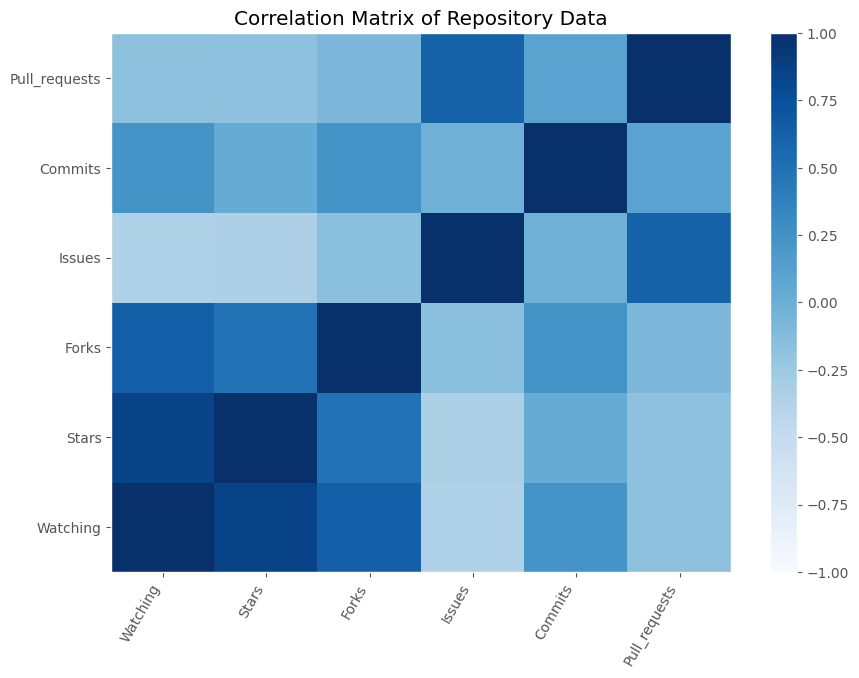

In [201]:
#plot heat map for numerical variables 

plt.figure(figsize=(10, 7))

#create heat map from correlation matrix using pcolor
heat_map = plt.pcolor(project_info_corr, cmap=plt.cm.Blues,vmin = -1, vmax =1)

#create axis labels and ticks:
ax_labels = project_info_corr.columns #extract column names for labels
ticks = np.arange(len(ax_labels)) + 0.5 #place ticks in center of cells

#add specifications
plt.colorbar(heat_map) #add legend
#add labels based on corresponding columns
plt.xticks(ticks, ax_labels,rotation = 60, ha = "right") #rotate and adjust position
plt.yticks(ticks, ax_labels)
plt.title("Correlation Matrix of Repository Data") #add title

plt.show()

****Scatter Matrix:****

In [212]:
#create scatter matrix using seaborn
import seaborn as sns
sns.pairplot(project_info_sub)

**Your Interpretation:** 

Both the heat map and scatter matrix indicate which variables have the highest correlation with one another. These show that the Watching, Stars, and Forks values all have a linear relationship. Repositories that have a greater number of users 'watching' also are more likely to have a higher rating (stars) and number of forks.

### 2.2. Linear regression

1. Use linear regression to try to predict the number of Stars based on Forks, Pull Requests, and Commits. Discuss the R-squared , F-statistic p-value, and coefficient  p-values. 
+ Develop another model which is better. Explain why it is better and interpret your results. Hint: try using other variables such as watching and/or Contributors. 

In [233]:
#develop linear regression model
import statsmodels.formula.api as sm

repo_model = sm.ols(formula = "Stars ~ Forks + Pull_requests + Commits", data = project_info).fit()
repo_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Stars   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     5.165
Date:                Sat, 01 Mar 2025   Prob (F-statistic):            0.00381
Time:                        18:56:38   Log-Likelihood:                -608.18
No. Observations:                  48   AIC:                             1224.
Df Residuals:                      44   BIC:                             1232.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      9.773e+04   2.25e+04      4.341      0.000    5.24e+04    1.43e+05
Forks             2.4933      0.672      3.709      0.001       1.139       3.848
Pull_requests   -20.2674     24.116     -0.840      0.405     -68.871      28.336
Commits          -0.0356      0.063     -0.562      0.577      -0.163       0.092
==============================================================================
Omnibus:                        5.592   Durbin-Watson:                   0.743
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                4.434
Skew:                           0.613   Prob(JB):                        0.109
Kurtosis:                       3.846   Cond. No.                     3.77e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.77e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [250]:
#second model - using Watching

repo_model_b = sm.ols(formula = "Stars ~ Watching + Commits", data = project_info).fit()
repo_model_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Stars   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     74.04
Date:                Sat, 01 Mar 2025   Prob (F-statistic):           5.87e-15
Time:                        19:18:51   Log-Likelihood:                -580.47
No. Observations:                  48   AIC:                             1167.
Df Residuals:                      45   BIC:                             1173.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.922e+04   1.05e+04      5.642      0.000    3.81e+04    8.04e+04
Watching      30.9055      2.541     12.163      0.000      25.788      36.023
Commits       -0.0862      0.035     -2.469      0.017      -0.157      -0.016
==============================================================================
Omnibus:                        0.673   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.714   Jarque-Bera (JB):                0.566
Skew:                           0.256   Prob(JB):                        0.754
Kurtosis:                       2.854   Cond. No.                     3.16e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.16e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Your Interpretation:** 

The first model, which uses Forks, Pull Requests, and Commits to predict the number of Stars for a particular repository performs fairly poorly. The R-squared was 0.260 and the F-statistic was 5.165. These low values indicate that the model is a poor fit. Additionally, only the Forks variable has a significant p-value. 

The second model, which uses Watching and Commits, has a higher R-squared (0.767) and F-statistic (74.04), as well as a much lower associated p-value for the F-statistic. These changes indicate that this model performs better than the original.